In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score, precision_score, recall_score


from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [2]:
cooper = pd.read_csv('copper_Set.csv')
cooper.head(5)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


# Pre-processing

In [3]:
def fill_na_values(df):
    median_col = ['quantity_tons', 'customer', 'country', 'application', 'width', 'selling_price', 'thickness']
    for col in median_col:
        df[col] = df[col].apply(lambda x: np.nan if x <= 0 else x)  # Replace non-positive values with NaN
        df[col] = df[col].fillna(df[col].median())

    mode_col = ['item_date', 'delivery_date', 'status']
    for col in mode_col:
        df[col] = df[col].fillna(df[col].mode().iloc[0])       
    return df

def cleaning_df(df):
    
    cleaning = (cooper
        .rename(columns={'quantity tons':'quantity_tons', 'item type':'item_type', 'delivery date':'delivery_date'})  #naming the column 
        .assign(
            item_date=lambda x: pd.to_datetime(x['item_date'], format='%Y%m%d', errors='coerce'),
            delivery_date=lambda x: pd.to_datetime(x['delivery_date'], format='%Y%m%d', errors='coerce'),  #fixing the frature to datetime dtypes
            material_ref=lambda x: x['material_ref']
                        .str.strip('0')
                        .str.replace(r'[_+-]', '', regex=True)
                        .fillna('Unknown')
                        .astype('category'),
            quantity_tons=lambda x: pd.to_numeric(x['quantity_tons'], errors='coerce').apply(lambda y: np.nan if y <= 0 else y),
            customer=lambda x: x['customer'],
            country=lambda x: x['country'],
            application=lambda x: x['application'],
            selling_price=lambda x: pd.to_numeric(x['selling_price'], errors='coerce').apply(lambda y: np.nan if y <= 0 else y))
        .dropna()         #droping the null values becouse they are less the one percen
        .pipe(fill_na_values)
        .dropna()
        .astype({'country':'int32'})
        .reset_index()
        .drop(columns=['id','material_ref','index'])
        )
    return cleaning

df = cleaning_df(cooper)

In [4]:
df

,item_date,quantity_tons,customer,country,status,item_type,application,thickness,width,product_ref,delivery_date,selling_price
0,2021-04-01,54.151139,30156308.0,28,Won,W,10.0,2.00,1500.0,1670798778,2021-07-01,854.00
1,2021-04-01,768.024839,30202938.0,25,Won,W,41.0,0.80,1210.0,1668701718,2021-04-01,1047.00
2,2021-04-01,386.127949,30153963.0,30,Won,WI,28.0,0.38,952.0,628377,2021-01-01,644.33
3,2021-04-01,202.411065,30349574.0,32,Won,S,59.0,2.30,1317.0,1668701718,2021-01-01,768.00
4,2021-04-01,785.526262,30211560.0,28,Won,W,10.0,4.00,2000.0,640665,2021-03-01,577.00
...,...,...,...,...,...,...,...,...,...,...,...,...
181615,2020-07-02,106.783299,30200854.0,25,Won,W,41.0,0.96,1240.0,164141591,2020-07-01,602.00
181616,2020-07-02,102.482422,30200854.0,25,Won,W,41.0,0.96,1220.0,164141591,2020-07-01,591.00
181617,2020-07-02,208.086469,30200854.0,25,Won,W,41.0,0.95,1500.0,164141591,2020-07-01,589.00
181618,2020-07-02,4.235594,30200854.0,25,Won,W,41.0,0.71,1250.0,164141591,2020-07-01,619.00


# EDA

In [5]:
df.to_csv('clean_copper_data.csv',index=False)

In [6]:
EDA = df.copy(True)
EDA.head(6)

,item_date,quantity_tons,customer,country,status,item_type,application,thickness,width,product_ref,delivery_date,selling_price
0,2021-04-01,54.151139,30156308.0,28,Won,W,10.0,2.00,1500.0,1670798778,2021-07-01,854.00
1,2021-04-01,768.024839,30202938.0,25,Won,W,41.0,0.80,1210.0,1668701718,2021-04-01,1047.00
2,2021-04-01,386.127949,30153963.0,30,Won,WI,28.0,0.38,952.0,628377,2021-01-01,644.33
3,2021-04-01,202.411065,30349574.0,32,Won,S,59.0,2.30,1317.0,1668701718,2021-01-01,768.00
4,2021-04-01,785.526262,30211560.0,28,Won,W,10.0,4.00,2000.0,640665,2021-03-01,577.00
5,2021-04-01,225.790676,30202938.0,25,Won,W,41.0,1.50,1265.0,1668701718,2021-04-01,983.00


In [7]:
EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181620 entries, 0 to 181619
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   item_date      181620 non-null  datetime64[ns]
 1   quantity_tons  181620 non-null  float64       
 2   customer       181620 non-null  float64       
 3   country        181620 non-null  int32         
 4   status         181620 non-null  object        
 5   item_type      181620 non-null  object        
 6   application    181620 non-null  float64       
 7   thickness      181620 non-null  float64       
 8   width          181620 non-null  float64       
 9   product_ref    181620 non-null  int64         
 10  delivery_date  181620 non-null  datetime64[ns]
 11  selling_price  181620 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int32(1), int64(1), object(2)
memory usage: 15.9+ MB


In [8]:
EDA.describe().T

,count,mean,min,25%,50%,75%,max,std
item_date,181620,2020-11-26 23:01:19.207135744,2020-07-02 00:00:00,2020-09-29 00:00:00,2020-11-30 00:00:00,2021-02-03 00:00:00,2021-04-01 00:00:00,NaN
quantity_tons,181620.0,5876.596151,0.00001,10.968706,30.364095,67.163321,1000000000.0,2349417.502544
customer,181620.0,30232507.535371,12458.0,30196884.0,30205242.0,30280416.0,30408185.0,100565.096026
country,181620.0,44.894009,25.0,26.0,30.0,78.0,113.0,24.404547
application,181620.0,25.615571,2.0,10.0,15.0,41.0,99.0,17.753855
thickness,181620.0,2.550501,0.18,0.7,1.5,3.0,400.0,2.976518
width,181620.0,1295.26948,1.0,1179.75,1250.0,1500.0,2990.0,261.650874
product_ref,181620.0,474020443.176787,611728.0,611993.0,640665.0,1332077137.0,1722207579.0,717535803.274884
delivery_date,181620,2021-01-25 22:48:39.960356608,2019-04-01 00:00:00,2020-11-01 00:00:00,2021-01-01 00:00:00,2021-04-01 00:00:00,2022-01-01 00:00:00,NaN
selling_price,181620.0,1918.487123,0.1,669.0,812.0,953.0,100001015.0,331843.136785


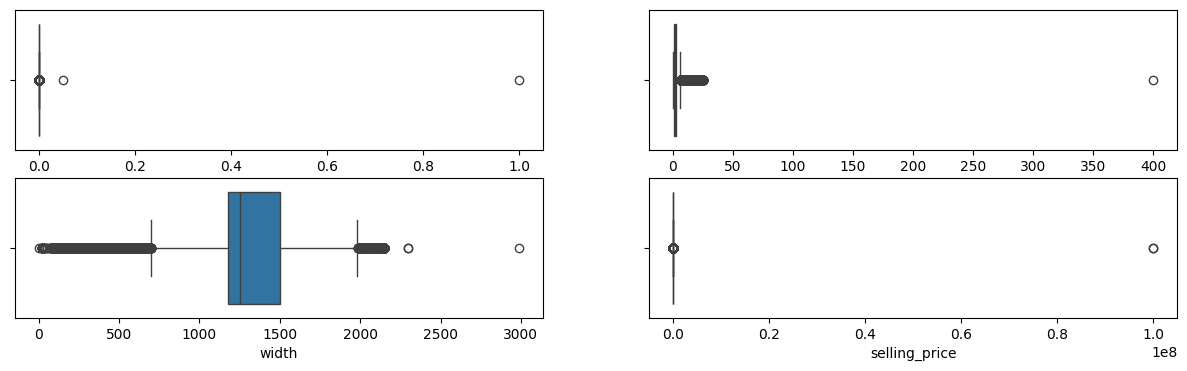

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,4)

a = sns.boxplot(EDA['quantity_tons'] , orient = "h" , ax=axes[0][0])
a = sns.boxplot(EDA['thickness'] , orient = "h" , ax=axes[0][1])
a = sns.boxplot(EDA['width'] , orient = "h" , ax=axes[1][0])
a = sns.boxplot(EDA['selling_price'] , orient = "h" , ax=axes[1][1])

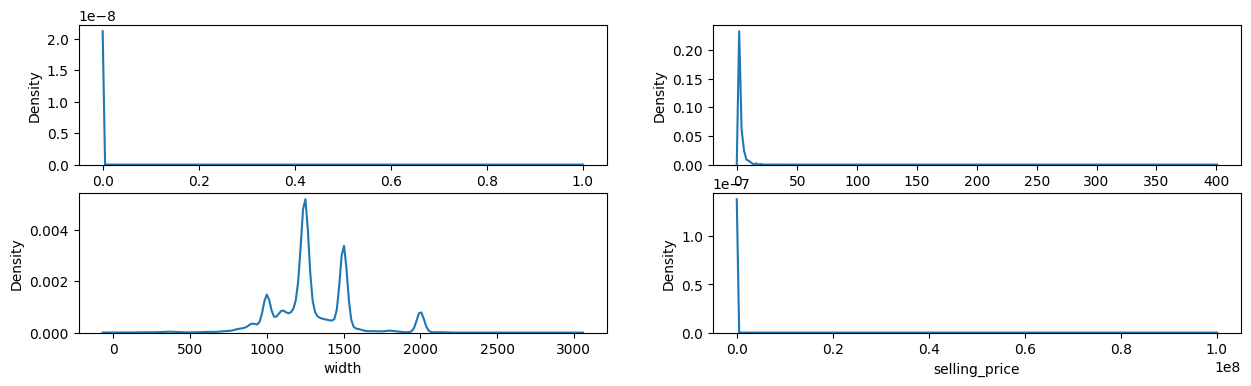

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,4)
a = sns.kdeplot(EDA['quantity_tons'] , ax=axes[0][0])
a = sns.kdeplot(EDA['thickness'] , ax=axes[0][1])
a = sns.kdeplot(EDA['width'] , ax=axes[1][0])
a = sns.kdeplot(EDA['selling_price'] , ax=axes[1][1])

# IQR-Inter Quartile Range

In [11]:
outlier_columns = ['quantity_tons', 'thickness', 'width', 'selling_price']
before_stats = EDA[outlier_columns].describe().T
before_stats

,count,mean,std,min,25%,50%,75%,max
quantity_tons,181620.0,5876.596151,2.349418e+06,0.00001,10.968706,30.364095,67.163321,1.000000e+09
thickness,181620.0,2.550501,2.976518e+00,0.18000,0.700000,1.500000,3.000000,4.000000e+02
width,181620.0,1295.269480,2.616509e+02,1.00000,1179.750000,1250.000000,1500.000000,2.990000e+03
selling_price,181620.0,1918.487123,3.318431e+05,0.10000,669.000000,812.000000,953.000000,1.000010e+08


In [12]:
for column in outlier_columns:
    Q1 = EDA[column].quantile(0.25)
    Q3 = EDA[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    EDA[column] = EDA[column].clip(lower_bound, upper_bound)

# Calculate summary statistics after removing outliers
after_stats = EDA[outlier_columns].describe().T

after_stats

,count,mean,std,min,25%,50%,75%,max
quantity_tons,181620.0,49.177372,47.997658,0.00001,10.968706,30.364095,67.163321,151.455243
thickness,181620.0,2.245032,1.890410,0.18000,0.700000,1.500000,3.000000,6.450000
width,181620.0,1297.040627,249.045465,699.37500,1179.750000,1250.000000,1500.000000,1980.375000
selling_price,181620.0,819.140413,209.057638,243.00000,669.000000,812.000000,953.000000,1379.000000


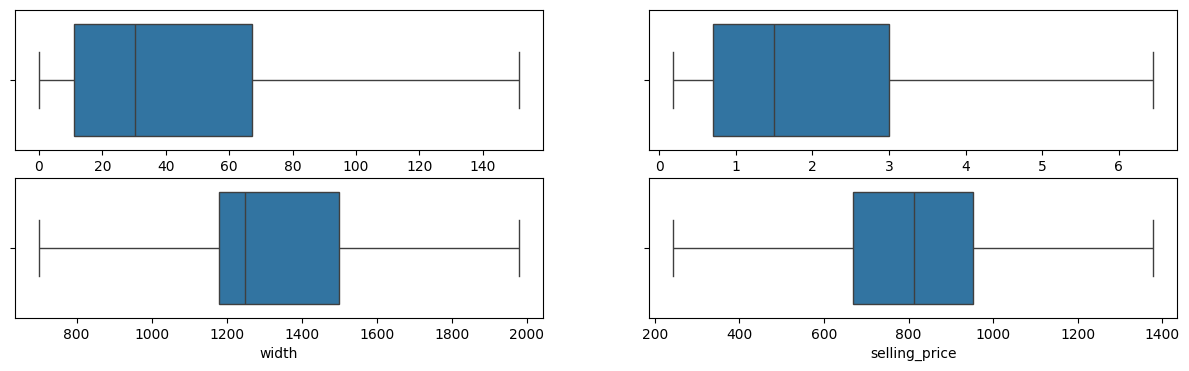

In [13]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,4)

a = sns.boxplot(EDA['quantity_tons'] , orient = "h" , ax=axes[0][0])
a = sns.boxplot(EDA['thickness'] , orient = "h" , ax=axes[0][1])
a = sns.boxplot(EDA['width'] , orient = "h" , ax=axes[1][0])
a = sns.boxplot(EDA['selling_price'] , orient = "h" , ax=axes[1][1])

<Axes: >

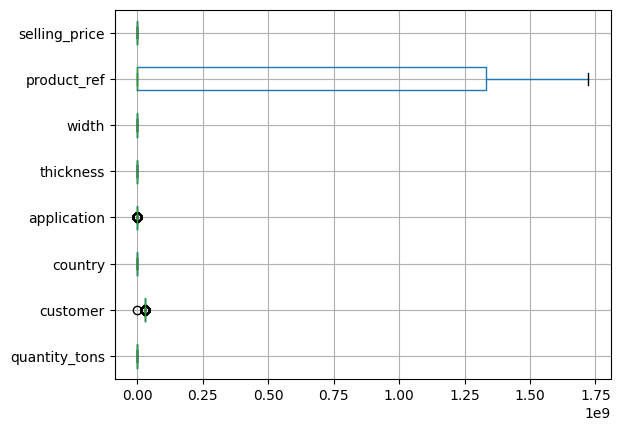

In [14]:
EDA.boxplot(vert=0)

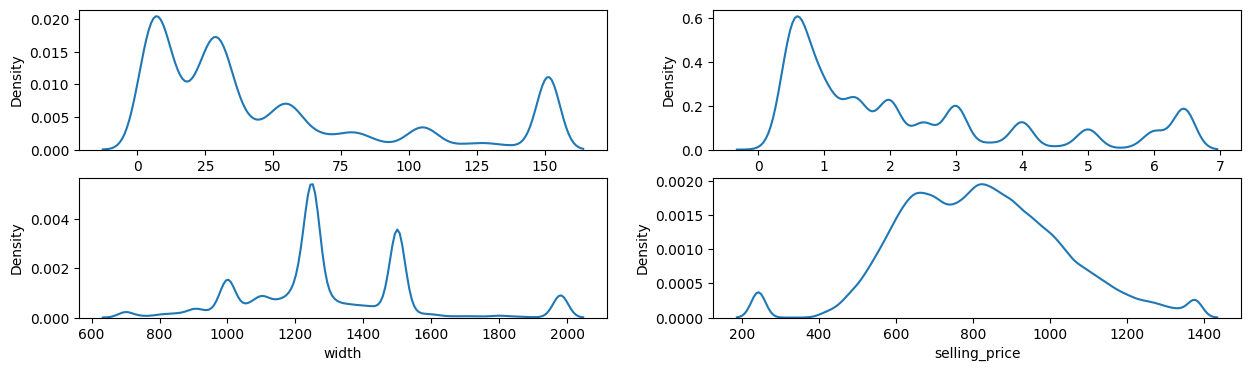

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,4)
a = sns.kdeplot(EDA['quantity_tons'] , ax=axes[0][0])
a = sns.kdeplot(EDA['thickness'] , ax=axes[0][1])
a = sns.kdeplot(EDA['width'] , ax=axes[1][0])
a = sns.kdeplot(EDA['selling_price'] , ax=axes[1][1])

In [16]:
print(EDA["quantity_tons"].skew())
print(EDA["thickness"].skew())
print(EDA["width"].skew())
print(EDA["selling_price"].skew())

1.121783230641624
1.0613177481287255
0.6684450270216287
0.13856585714900282


# To Treate the Skewness using **yeojohnson** from scipy 

In [17]:
from scipy import stats

columns_to_transform = ['quantity_tons','thickness','selling_price']

for col in columns_to_transform:
    EDA[f'{col}_yeojohnson'], _ = stats.yeojohnson(EDA[col])
    print(f"Skewness of {col}_yeojohnson: {EDA[f'{col}_yeojohnson'].skew()}")

Skewness of quantity_tons_yeojohnson: -0.049124455113153845
Skewness of thickness_yeojohnson: 0.13507337658194077
Skewness of selling_price_yeojohnson: 0.035954846827831725


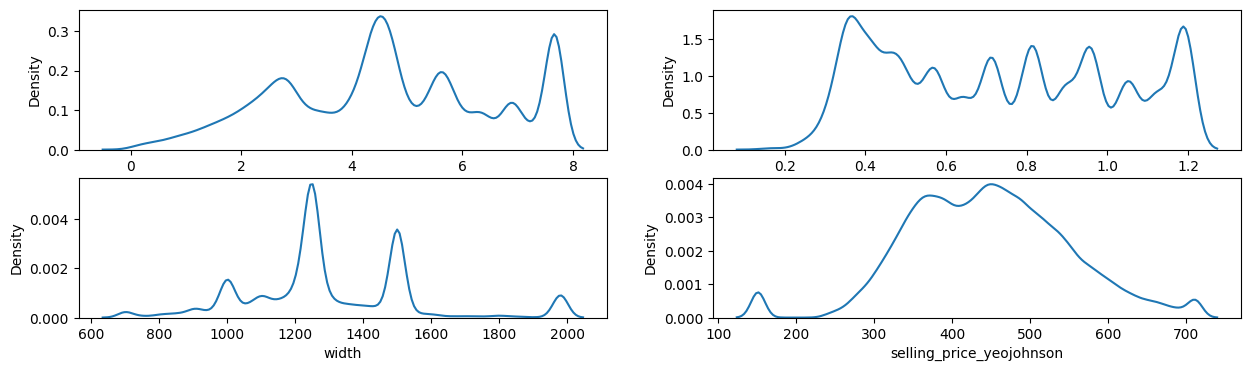

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15,4)
a = sns.kdeplot(EDA['quantity_tons_yeojohnson'] , ax=axes[0][0])
a = sns.kdeplot(EDA['thickness_yeojohnson'] , ax=axes[0][1])
a = sns.kdeplot(EDA['width'] , ax=axes[1][0])
a = sns.kdeplot(EDA['selling_price_yeojohnson'] , ax=axes[1][1])

In [19]:
EDA.head(3)

,item_date,quantity_tons,customer,country,status,item_type,application,thickness,width,product_ref,delivery_date,selling_price,quantity_tons_yeojohnson,thickness_yeojohnson,selling_price_yeojohnson
0,2021-04-01,54.151139,30156308.0,28,Won,W,10.0,2.00,1500.0,1670798778,2021-07-01,854.00,5.59494,0.816394,464.688771
1,2021-04-01,151.455243,30202938.0,25,Won,W,41.0,0.80,1210.0,1668701718,2021-04-01,1047.00,7.67168,0.499430,557.573775
2,2021-04-01,151.455243,30153963.0,30,Won,WI,28.0,0.38,952.0,628377,2021-01-01,644.33,7.67168,0.294239,361.170269


# FEATURE ENGINEERING

Label encoding , normalize the data!

In [20]:
data=EDA.copy(True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181620 entries, 0 to 181619
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   item_date                 181620 non-null  datetime64[ns]
 1   quantity_tons             181620 non-null  float64       
 2   customer                  181620 non-null  float64       
 3   country                   181620 non-null  int32         
 4   status                    181620 non-null  object        
 5   item_type                 181620 non-null  object        
 6   application               181620 non-null  float64       
 7   thickness                 181620 non-null  float64       
 8   width                     181620 non-null  float64       
 9   product_ref               181620 non-null  int64         
 10  delivery_date             181620 non-null  datetime64[ns]
 11  selling_price             181620 non-null  float64       
 12  qu

In [21]:
data['delivery_time_taken']=(data['item_date']-data['delivery_date']).abs().dt.days

# Correlation


# Heatmap

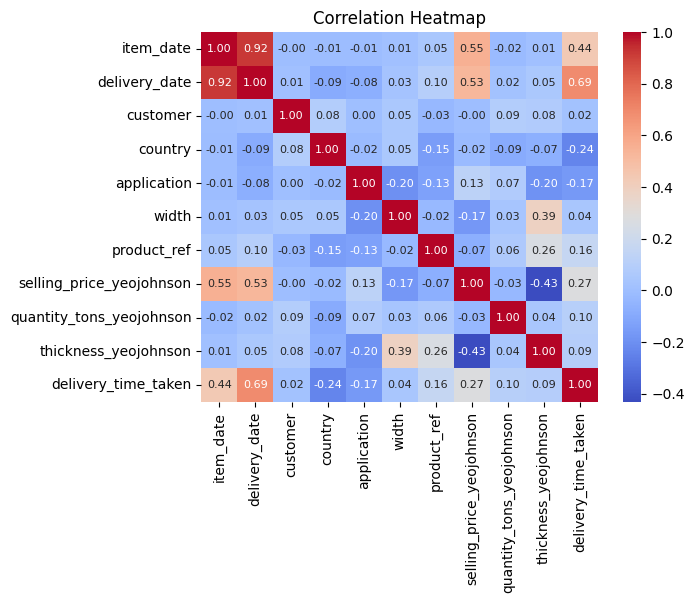

In [22]:
columns_of_interest = ['item_date','delivery_date','customer','country','application','width','product_ref','selling_price_yeojohnson','quantity_tons_yeojohnson','thickness_yeojohnson','delivery_time_taken']
corr=data[columns_of_interest].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size":8})
plt.title('Correlation Heatmap')
plt.show()

In [23]:
data.drop(columns=['quantity_tons','thickness','selling_price','delivery_date','item_date'], inplace=True)

data.head()

,customer,country,status,item_type,application,width,product_ref,quantity_tons_yeojohnson,thickness_yeojohnson,selling_price_yeojohnson,delivery_time_taken
0,30156308.0,28,Won,W,10.0,1500.000,1670798778,5.59494,0.816394,464.688771,91
1,30202938.0,25,Won,W,41.0,1210.000,1668701718,7.67168,0.499430,557.573775,0
2,30153963.0,30,Won,WI,28.0,952.000,628377,7.67168,0.294239,361.170269,90
3,30349574.0,32,Won,S,59.0,1317.000,1668701718,7.67168,0.865979,422.599935,90
4,30211560.0,28,Won,W,10.0,1980.375,640665,7.67168,1.053267,327.207457,31


In [24]:
data["customer"].nunique()

1167

# FINDING UNIQUE VALUE


In [25]:
data['country'] = data['country'].astype('str')
country=data['country'].unique()
status=data['status'].unique()
item=data['item_type'].unique()
print(country)
print(status)
print(item)

['28' '25' '30' '32' '38' '78' '27' '77' '113' '79' '26' '39' '40' '84'
 '80' '107' '89']
['Won' 'Draft' 'To be approved' 'Lost' 'Not lost for AM' 'Wonderful'
 'Revised' 'Offered' 'Offerable']
['W' 'WI' 'S' 'Others' 'PL' 'IPL' 'SLAWR']


# ENCODE THE CATEGORICAL COLUMN


In [26]:
from sklearn.preprocessing import OrdinalEncoder

encode = OrdinalEncoder()
data["country"] = encode.fit_transform(data[["country"]])
transformed_country = data["country"].unique()

data['status'] = encode.fit_transform(data[['status']])
transformed_status = data['status'].unique()

data["item_type"] = encode.fit_transform(data[["item_type"]])
transformed_item = data["item_type"].unique()


In [27]:
import pickle

file_path='country.pkl'
file_path2='status.pkl'
file_path3='item_type.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(transformed_country, file)
with open(file_path2, 'wb') as file:
    pickle.dump(transformed_status, file)
with open(file_path3, 'wb') as file:
    pickle.dump(transformed_item, file)

print(f'Pickle file created: {file_path}, {file_path2},{file_path3}')

Pickle file created: country.pkl, status.pkl,item_type.pkl


In [28]:
data.head(3)

,customer,country,status,item_type,application,width,product_ref,quantity_tons_yeojohnson,thickness_yeojohnson,selling_price_yeojohnson,delivery_time_taken
0,30156308.0,5.0,7.0,5.0,10.0,1500.0,1670798778,5.59494,0.816394,464.688771,91
1,30202938.0,2.0,7.0,5.0,41.0,1210.0,1668701718,7.67168,0.499430,557.573775,0
2,30153963.0,6.0,7.0,6.0,28.0,952.0,628377,7.67168,0.294239,361.170269,90


In [29]:
from sklearn import preprocessing

X = data[['quantity_tons_yeojohnson','thickness_yeojohnson','width','status','country','item_type','application','product_ref','delivery_time_taken']].values
y = data[['selling_price_yeojohnson']].values

scalled_data = StandardScaler().fit(X)
X = scalled_data.transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
with open('scaling.pkl', 'wb') as file:
    pickle.dump(scalled_data, file)

In [31]:
# # Create an instance of each regression model
# et_model = ExtraTreesRegressor()                   # Extra Tree Regressor
# xgb_model = XGBRegressor()                         # Extreme Gradient Boost Regressor
# dt_model = DecisionTreeRegressor()                 # Decision Tree Regressor

# # Train the models
# et_model.fit(X_train, y_train)
# xgb_model.fit(X_train,y_train)
# dt_model.fit(X_train, y_train)


# # Make predictions on the test set
# et_preds = et_model.predict(X_test)
# xgb_preds = xgb_model.predict(X_test)
# dt_preds = dt_model.predict(X_test)

# # Evaluate the models

# et_mse = mean_squared_error(y_test, et_preds)
# et_mae = mean_absolute_error(y_test, et_preds)
# et_r2 = r2_score(y_test, et_preds)

# xgb_mse = mean_squared_error(y_test, xgb_preds)
# xgb_mae = mean_absolute_error(y_test, xgb_preds)
# xgb_r2 = r2_score(y_test, xgb_preds)

# dt_mse = mean_squared_error(y_test, dt_preds)
# dt_mae = mean_absolute_error(y_test, dt_preds)
# dt_r2 = r2_score(y_test, dt_preds)

In [32]:
# print(f"ExtraTreeRegressor    MSE: {et_mse},  MAE: {et_mae},  R2: {et_r2}")
# print(f"XGBRegressor          MSE: {xgb_mse},  MAE: {xgb_mae},  R2: {xgb_r2}")
# print(f"DecisionTreeRegressor MSE: {dt_mse},  MAE: {dt_mae}, R2: {dt_r2}")

In [33]:
models = {"ExtraTreeRegressor" : ExtraTreesRegressor(),
          'XGBRegressor' : XGBRegressor(),
          'DecisionTreeRegressor': DecisionTreeRegressor() 
}
n = X_test.shape[0]  # number of samples
p = X_test.shape[1]  # number of predictors

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    Adjusted_R2 = 1 - ((1 - R2) * (n - 1) / (n - p - 1))
    
    print("+----------------------------------+")
    print(f"   -- {list(models.keys())[i]} --    ")
    print("+----------------------------------+")
    print("| Model performance on testing set |")
    print("+----------------------------------+")
    print("|         MSE :{:.4f}           |".format(MSE))
    print("|         MAE :{:.4f}             |".format(MAE))
    print("|         R2  :{:.4f}              |".format(R2))
    print("| Adjusted R2 : {:.4f}             |".format(Adjusted_R2))
    print("+----------------------------------+")
    print(f'='*36)

+----------------------------------+
   -- ExtraTreeRegressor --    
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|         MSE :1058.6956           |
|         MAE :19.9144             |
|         R2  :0.8995              |
| Adjusted R2 : 0.8995             |
+----------------------------------+
+----------------------------------+
   -- XGBRegressor --    
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|         MSE :1942.8243           |
|         MAE :33.2240             |
|         R2  :0.8156              |
| Adjusted R2 : 0.8156             |
+----------------------------------+
+----------------------------------+
   -- DecisionTreeRegressor --    
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|         MSE :1851.8672           |
|         MAE :23.3100             |
|         R2  :0.82

In [34]:
# ExtraTreeRegressor    MSE: 0.08928480145014409,  MAE: 0.1810585737304625,  R2: 0.9909460650211457
# XGBRegressor          MSE: 0.16476380958615172,  MAE: 0.3037891126118616,  R2: 0.9356622252898586
# DecisionTreeRegressor MSE: 0.14721973702174534,  MAE: 0.2042058785439577, R2: 0.9531609336034718

# Hyperparmeter Tuaining

In [35]:
# from sklearn.model_selection import GridSearchCV

# ET_param_grid = {
#     'n_estimators': [100],
#     'max_depth': [10, None],
#     'min_samples_split': [2,10],
#     'min_samples_leaf': [1, 2,],
#     'max_features': ['sqrt', 'log2']
# }
# gridcv_models = [("ET", ExtraTreesRegressor(), ET_param_grid )]
# gridcv_models

[('ET',
  ExtraTreesRegressor(),
  {'n_estimators': [100],
   'max_depth': [10, None],
   'min_samples_split': [2, 10],
   'min_samples_leaf': [1, 2],
   'max_features': ['sqrt', 'log2']})]

In [38]:
# model_param = {}
# for name, model, params in gridcv_models:
#     grid_search  = GridSearchCV(estimator=model,
#                                param_grid=params,
#                                cv=3,
#                                verbose=2,
#                                n_jobs=-1
#                               )
#     grid_search.fit(X_train, y_train)
#     model_param[name] = grid_search.best_params_
    
# for model_name in model_param:
#     print(f"===========Best Params for {model_name}===========")
#     print(model_param[model_name])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
===========Best Params for ET===========
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [39]:
# Fitting 3 folds for each of 16 candidates, totalling 48 fits
# ===========Best Params for ET===========
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [44]:
models = {
    'ExtraTreeRegression' : ExtraTreesRegressor()
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train,y_train)
    
    y_pred = model.predict(X_test)
    
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    Adjusted_R2 = 1 - ((1 - R2) * (n - 1) / (n - p - 1))
    
    print("+----------------------------------+")
    print(f"   -- {list(models.keys())[i]} --    ")
    print("+----------------------------------+")
    print("| Model performance on testing set |")
    print("+----------------------------------+")
    print("|         MSE :{:.4f}           |".format(MSE))
    print("|         MAE :{:.4f}             |".format(MAE))
    print("|         R2  :{:.4f}              |".format(R2))
    print("| Adjusted R2 : {:.4f}             |".format(Adjusted_R2))
    print("+----------------------------------+")
    print(f'='*36)

+----------------------------------+
   -- ExtraTreeRegression --    
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|         MSE :1056.1196           |
|         MAE :19.9365             |
|         R2  :0.8998              |
| Adjusted R2 : 0.8998             |
+----------------------------------+


In [45]:
et_model = ExtraTreesRegressor()
et_model_reg=et_model.fit(X_train, y_train)

with open('et_reg.pkl', 'wb') as file:
    pickle.dump(et_model_reg, file)
    
with open('et_reg.pkl', 'rb') as file:
    et_reg = pickle.load(file)

In [46]:
# # Function to transform input based on mappings
# def get_transformed_value(value, original_list, transformed_list):
#     try:
#         return transformed_list[original_list.index(value)]
#     except ValueError:
#         print(f"{value} not found in list.")
#         return None

In [47]:
country_to_transformed = dict(zip(country, transformed_country))
item_to_transformed = dict(zip(item, transformed_item))
status_to_transformed = dict(zip(status, transformed_status))


# Lookup for country
new_sample_co = input("Enter a country: ")
c = country_to_transformed.get(new_sample_co)
if c is None:
    print("Country not found.")
    exit()

# Lookup for item type
new_sample_it = input("Enter an item type: ")
it = item_to_transformed.get(new_sample_it)

if it is None:
    print("item type not found.")
    exit()

# Lookup for status
new_sample_st = input("Enter a status: ")
s = status_to_transformed.get(new_sample_st)

if s is None:
    print("ststus not found.")
    exit()

# Testing prediction
try:
    x = [5.594940, 0.816394, 1500, s, c, it, 10.0, 1670798778, 91]
    x = np.array(x).reshape(1, -1)  # Reshape to 2D array
    new_sample_scaled = scalled_data.transform(x)
    new_pred = et_model.predict(new_sample_scaled)
    print('Predicted selling price:', new_pred)
except Exception as e:
    print(f"Error: {e}. Please enter valid values.")

Predicted selling price: [443.57080903]


In [48]:
data.head(1)

,customer,country,status,item_type,application,width,product_ref,quantity_tons_yeojohnson,thickness_yeojohnson,selling_price_yeojohnson,delivery_time_taken
0,30156308.0,5.0,7.0,5.0,10.0,1500.0,1670798778,5.59494,0.816394,464.688771,91


In [49]:
x = data[[ 'quantity_tons_yeojohnson','thickness_yeojohnson','width','selling_price_yeojohnson','country','item_type','application','product_ref','delivery_time_taken']].values
Y = data[['status']].values

scaler_classify = StandardScaler().fit(x)
x = scaler_classify.transform(x)

# Split the dataset into training and testing sets
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.3, random_state=20)

In [50]:
with open('scaling_classify.pkl', 'wb') as file:
    pickle.dump(scaler_classify, file)

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [52]:
models = {"RandomForestClassifier" : RandomForestClassifier(),             # Random Forest Classifier
          'XGBClassifier' : xgb.XGBClassifier(),
          'DecisionTreeClassifier': DecisionTreeClassifier() 
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train, Y_train)
    
    # Predictions
    Y_train_pred = model.predict(x_train)
    Y_test_pred = model.predict(x_test)
    
    # Training metrics
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    train_precision = precision_score(Y_train, Y_train_pred, average='weighted')
    train_recall = recall_score(Y_train, Y_train_pred, average='weighted')
    train_f1 = f1_score(Y_train, Y_train_pred, average='weighted')
    
    # Testing metrics
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_precision = precision_score(Y_test, Y_test_pred, average='weighted')
    test_recall = recall_score(Y_test, Y_test_pred, average='weighted')
    test_f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print("+----------------------------------+")
    print(f"   -- {list(models.keys())[i]} --    ")
    print("+----------------------------------+")
    print("| Model performance on training set |")
    print("+----------------------------------+")
    print(f"|   Accuracy: {train_accuracy:.4f}               |")
    print(f"|   Precision: {train_precision:.4f}              |")
    print(f"|   Recall: {train_recall:.4f}                 |")
    print(f"|   F1 Score: {train_f1:.4f}               |")
    print("+----------------------------------+")
    print("| Model performance on testing set |")
    print("+----------------------------------+")
    print(f"|   Accuracy: {test_accuracy:.4f}               |")
    print(f"|   Precision: {test_precision:.4f}              |")
    print(f"|   Recall: {test_recall:.4f}                 |")
    print(f"|   F1 Score: {test_f1:.4f}               |")
    print(f'='*50)

+----------------------------------+
   -- RandomForestClassifier --    
+----------------------------------+
| Model performance on training set |
+----------------------------------+
|   Accuracy: 1.0000               |
|   Precision: 1.0000              |
|   Recall: 1.0000                 |
|   F1 Score: 1.0000               |
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|   Accuracy: 0.9147               |
|   Precision: 0.9132              |
|   Recall: 0.9147                 |
|   F1 Score: 0.9127               |
+----------------------------------+
   -- XGBClassifier --    
+----------------------------------+
| Model performance on training set |
+----------------------------------+
|   Accuracy: 0.8587               |
|   Precision: 0.8565              |
|   Recall: 0.8587                 |
|   F1 Score: 0.8529               |
+----------------------------------+
| Model performance on testing set |
+---------

# Hyper parameter tuning for classification

In [53]:
# from sklearn.model_selection import GridSearchCV


# RF_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }
# gridcv_models = [("RF", RandomForestClassifier(), RF_param_grid)]
# gridcv_models

In [54]:
# model_param = {}
# for name, model, params in gridcv_models:                  #do not run took for ever???????????????????
#     grid_search  = GridSearchCV(estimator=model,
#                                param_grid=params,
#                                cv=3,
#                                verbose=2,
#                                n_jobs=-1
#                               )
#     grid_search.fit(x_train, Y_train)
#     model_param[name] = grid_search.best_params_
    
# for model_name in model_param:
#     print(f"===========Best Params for {model_name}===========")
#     print(model_param[model_name])

In [ ]:
# Fitting 3 folds for each of 324 candidates, totalling 972 fits
# ===========Best Params for RF===========
# {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [55]:
rf_model = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=100)

model_cls=rf_model.fit(x_train, Y_train)


with open('RF_class.pkl', 'wb') as file:
    pickle.dump(model_cls, file)

In [56]:
models = {
    "RandomForestClassifier": RandomForestClassifier(
        max_depth=30, 
        max_features='sqrt', 
        min_samples_leaf=1, 
        min_samples_split=2, 
        n_estimators=300
    )
}

for name, model in models.items():
    # Fit the model
    model.fit(x_train, Y_train)
    
    # Predictions
    Y_train_pred = model.predict(x_train)
    Y_test_pred = model.predict(x_test)
    
    # Training metrics
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    train_precision = precision_score(Y_train, Y_train_pred, average='weighted')
    train_recall = recall_score(Y_train, Y_train_pred, average='weighted')
    train_f1 = f1_score(Y_train, Y_train_pred, average='weighted')
    
    # Testing metrics
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_precision = precision_score(Y_test, Y_test_pred, average='weighted')
    test_recall = recall_score(Y_test, Y_test_pred, average='weighted')
    test_f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    # Print results
    print("+----------------------------------+")
    print(f"   -- {name} --    ")
    print("+----------------------------------+")
    print("| Model performance on training set |")
    print("+----------------------------------+")
    print(f"|   Accuracy: {train_accuracy:.4f}               |")
    print(f"|   Precision: {train_precision:.4f}              |")
    print(f"|   Recall: {train_recall:.4f}                 |")
    print(f"|   F1 Score: {train_f1:.4f}               |")
    print("+----------------------------------+")
    print("| Model performance on testing set |")
    print("+----------------------------------+")
    print(f"|   Accuracy: {test_accuracy:.4f}               |")
    print(f"|   Precision: {test_precision:.4f}              |")
    print(f"|   Recall: {test_recall:.4f}                 |")
    print(f"|   F1 Score: {test_f1:.4f}               |")
    print(f'='*50)

+----------------------------------+
   -- RandomForestClassifier --    
+----------------------------------+
| Model performance on training set |
+----------------------------------+
|   Accuracy: 1.0000               |
|   Precision: 1.0000              |
|   Recall: 1.0000                 |
|   F1 Score: 1.0000               |
+----------------------------------+
| Model performance on testing set |
+----------------------------------+
|   Accuracy: 0.9152               |
|   Precision: 0.9137              |
|   Recall: 0.9152                 |
|   F1 Score: 0.9130               |


In [57]:
country_to_transformed = dict(zip(country, transformed_country))
item_to_transformed = dict(zip(item, transformed_item))


new_sample_co = input("Enter a country: ")
c = country_to_transformed.get(new_sample_co)
if c is None:
    print("Country not found.")
    exit()

# Lookup for item type
new_sample_it = input("Enter an item type: ")
it = item_to_transformed.get(new_sample_it)

if it is None:
    print("item type not found.")
    exit()

try:
  x = [5.594940, 0.816394, 1500,464,c,it, 10.0, 1670798778, 91]
  x = np.array(x).reshape(1, -1)  # Reshape to 2D array
  new_sample_scaled = scaler_classify.transform(x)
  new_pred = rf_model.predict(new_sample_scaled)

  if new_pred==7:
      print('WON' )
  else:
      print('LOST')
except:
  print("enter valid values")

WON


In [59]:
data.head(1)

,customer,country,status,item_type,application,width,product_ref,quantity_tons_yeojohnson,thickness_yeojohnson,selling_price_yeojohnson,delivery_time_taken
0,30156308.0,5.0,7.0,5.0,10.0,1500.0,1670798778,5.59494,0.816394,464.688771,91
